In [79]:
pip install requests

    100% |████████████████████████████████| 71kB 4.2MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 8.3MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 9.2MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 11.2MB/s ta 0:00:01
You are using pip version 18.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install geopy

    100% |████████████████████████████████| 122kB 5.5MB/s ta 0:00:01
    100% |████████████████████████████████| 40kB 5.9MB/s eta 0:00:01
You are using pip version 18.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.impute import SimpleImputer
from geopy.geocoders import Nominatim


The first step we carried out was to import the data and check if the data is clean. 
1. Import the data and view the imported data
2. The data is clean and no columns are missing any values. 
3. All column entries except date column are the right datatype we want it to be. 
4. We converted the date column to datetime datatype.

In [2]:
#import the house data and view the imported data
house_data = pd.read_csv('https://raw.githubusercontent.com/Pelumioluwa/MBAN6110Class/main/Data/kc_house_data.csv')
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
#check the information of the data see if it is clean
house_data.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
#convert the date cloumn to datetime type 
house_data['date'] = pd.to_datetime(house_data['date'])

In [6]:
#check the summary of the columns
house_data['zipcode'].describe(include='all',datetime_is_numeric=True)

count    21613.000000
mean     98077.939805
std         53.505026
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64

The second step is to determine which of these columns have the strong correlation with price. To build a good preditctor, we would consider correlations which are moderate to strong (0.3 - 1). 

Therefore our independent variables are (square foot living, quality grade of materials, workmanship used, square foot of above the basement,Average size of interior housing living space for the closest 15 house, number of bathrooms,view, square foot of the basement, number of bedrooms). 

Although we received equal to or below 0.3 relationship for latitude,longtitude and zipcode. We would ignore this correlation as independently they do not say much but we would get a better view of the correlation with price when considered together.

In [25]:
# Calculate the correlation coefficients with the "Price" column
rel_correlation = house_data.corr()['price'].drop('price')
# Sort the correlations in descending order
strong_correlation = rel_correlation.abs().sort_values(ascending=False)

# Print the columns with the strongest relationships to "Price"
print(strong_correlation)

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
zipcode          0.053203
condition        0.036362
long             0.021626
id               0.016762
Name: price, dtype: float64


The third step is to visualize our data distribution. Through visualization, we are able to see what kind of relationship the other columns have with price and also If there are any outliers we should consider in these columns. Therefore, we would visualize the columns with the strong correlations against price. 
1. Price and square foot living 
2. Price and quality grade of materials, workmanship used 
3. Price and square foot of above the basement
4. Price and average size of interior housing living space for the closest 15 house
5. Price and number of bathrooms
6. Price and view
7. Price and square foot of the basement
8. Price number of bedrooms


Text(0.5, 1.0, 'Price vs Size_of_living_area_in_square_feet')

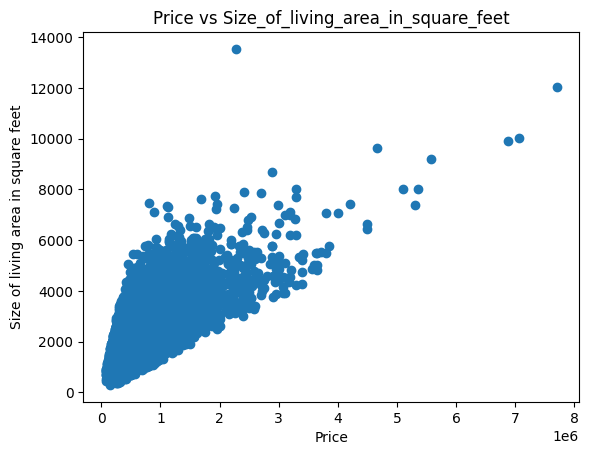

In [65]:
#price against number of size of living area in square feet
plt.scatter(house_data.price,house_data.sqft_living)
plt.xlabel('Price')
plt.ylabel('Size of living area in square feet')
plt.title("Price vs Size_of_living_area_in_square_feet")
# We can see that as the size of living area in square feet increases, price increase. 
# Therefore the size of living area in square feet positively affects the price of a house.
# There is an outlier in the data, but we would keep it in as it is not an outlier in the other data column

Text(0.5, 1.0, 'Price vs Quality grade')

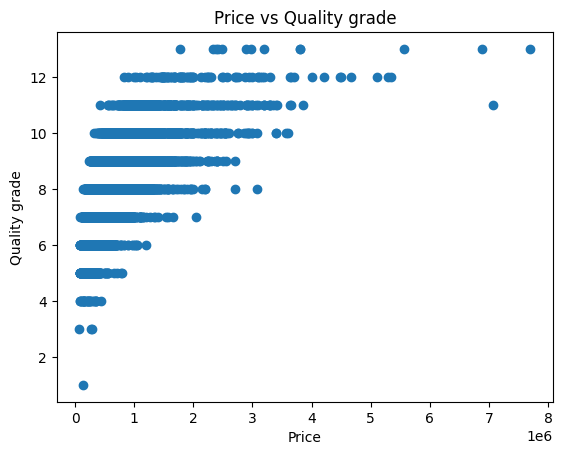

In [66]:
#price against quality grade of materials, workmanship used 
plt.scatter(house_data.price,house_data.grade)
plt.xlabel('Price')
plt.ylabel('Quality grade')
plt.title("Price vs Quality grade")
# We can see that as the quality grade, price increase. 
# Therefore the quality grade affects the price of a house.


Text(0.5, 1.0, 'Price vs sqft of above the basement')

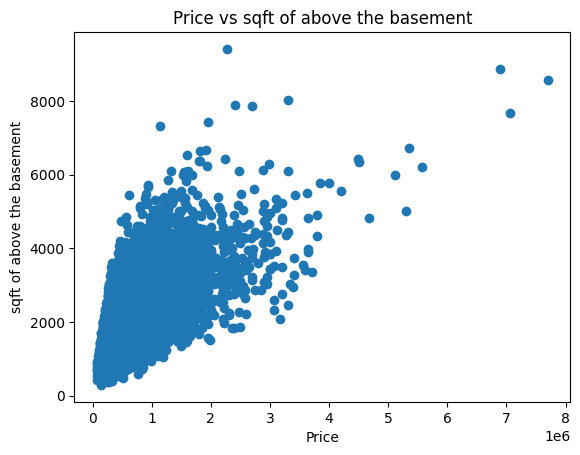

In [67]:
#price against square foot of above the basement 
plt.scatter(house_data.price,house_data.sqft_above)
plt.xlabel('Price')
plt.ylabel('sqft of above the basement')
plt.title("Price vs sqft of above the basement")
# We can see that as the size of area above the basement increases, price increase. 
# Therefore the size of area above the basement positively affects the price of a house.
# There are some outliers in the data, but we would keep them in as they are not outliers in the other data column


Text(0.5, 1.0, 'Price vs Sqft living space of closest 15 houses')

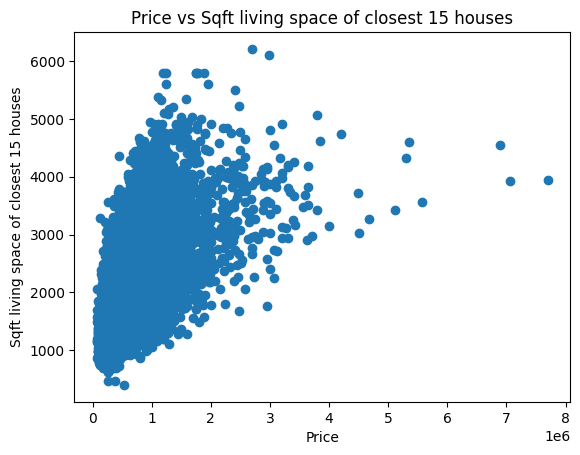

In [68]:
#price against average size of interior housing living space for the closest 15 house
plt.scatter(house_data.price,house_data.sqft_living15)
plt.xlabel('Price')
plt.ylabel('Sqft living space of closest 15 houses')
plt.title("Price vs Sqft living space of closest 15 houses")
# We can see that as the average size of living space of the closest 15 houses increases, price increase. 
# Therefore the average size of living space of the closest 15 houses positively affects the price of a house.
# There are some outliers in the data, but we would keep them in as they are not outliers in the other data column


Text(0.5, 1.0, 'Price vs number of bathrooms')

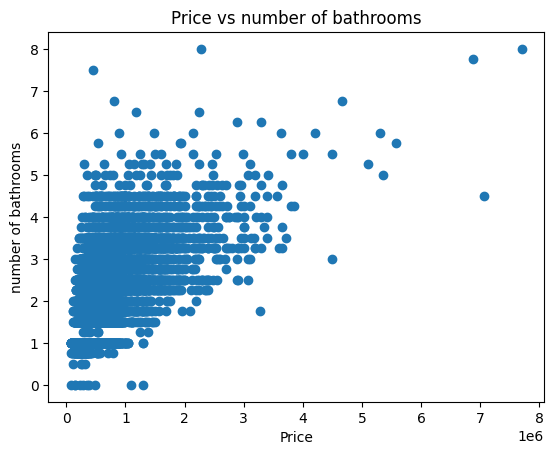

In [69]:
#price against number of bathrooms
plt.scatter(house_data.price,house_data.bathrooms)
plt.xlabel('Price')
plt.ylabel('number of bathrooms')
plt.title("Price vs number of bathrooms")
# We can see that as the number of bathrooms increases, price increase. 
# Therefore the number of bathrooms positively affects the price of a house.
# There are some outliers in the data, but we would keep them in as they are not outliers in the other data column


Text(0.5, 1.0, 'Price vs view')

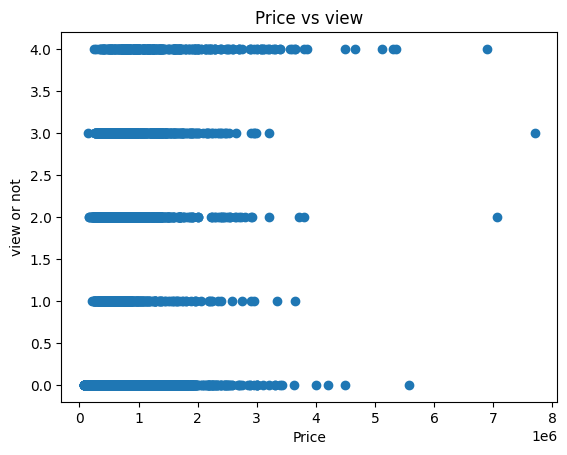

In [70]:
#price against the view
plt.scatter(house_data.price,house_data.view)
plt.xlabel('Price')
plt.ylabel('view or not')
plt.title("Price vs view")
# We can see that there is a relationship and the view positively affects the price of a house.


Text(0.5, 1.0, 'Price vs sqft of the basement')

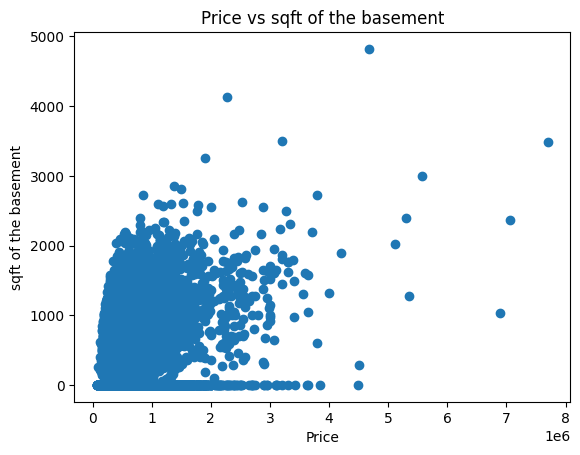

In [71]:
#price against square foot of the basement 
plt.scatter(house_data.price,house_data.sqft_basement)
plt.xlabel('Price')
plt.ylabel('sqft of the basement')
plt.title("Price vs sqft of the basement")
# We can see that as the size of the basement increases, price increase. 
# Therefore the size of the basement positively affects the price of a house.
# There are some outliers in the data, but we would keep them in as they are not outliers in the other data column


Text(0.5, 1.0, 'Price vs Number_of_bedrooms')

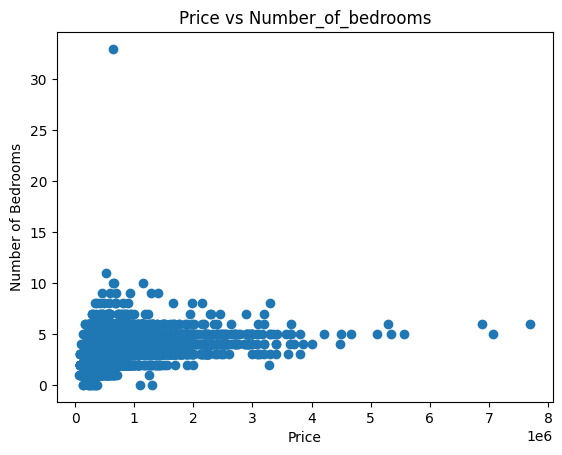

In [73]:
#price against number of bedrooms
plt.scatter(house_data.price,house_data.bedrooms)
plt.xlabel('Price')
plt.ylabel('Number of Bedrooms')
plt.title("Price vs Number_of_bedrooms")
# We can see there is a positive relationship with the number of bedroom and price
# however, the relationship is not strong 
# There are some outliers in the data, but we would keep them in as they are not outliers in the other data column

The Fourth step would be to carry out Feature engineering 
We would carry out feature engineering on the following columns.
Year of renovation to determine if a house has been renovated or not
longtitude, latitude and zipcode to determine the location of a house. 

From the above we would be able to determine the below
1. if a house has been renovated affects the price
   From the below, we recevied a correlation of .12 between price and renovated. This means that though a house was newly renovated, it did not have much effect on the price of the house.
2. if the location of a house affects the price
   

In [47]:
# Create function to classify if a house has been renovated or not
def renovate_cat(x):
    if x == 0:
        return '0'
    else:
        return '1'

In [57]:
# Create new column with year of renovation using renovate_cat()to categorize if a house has 
#been renovated or not
house_data['renovated'] = house_data['yr_renovated'].apply(renovate_cat)
house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,0
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,0
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,0
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,0


In [53]:
#convert the renovated cloumn to int type 
house_data['renovated'] =house_data['renovated'].astype(int)
print(house_data.dtypes)


id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
renovated          int64
dtype: object


In [54]:
# Calculate the correlation between 'price' and 'renovated'
correlation = house_data['price'].corr(house_data['renovated'])
print(correlation)


0.12609226271139498


Text(0.5, 1.0, 'Price vs Number_of_bedrooms')

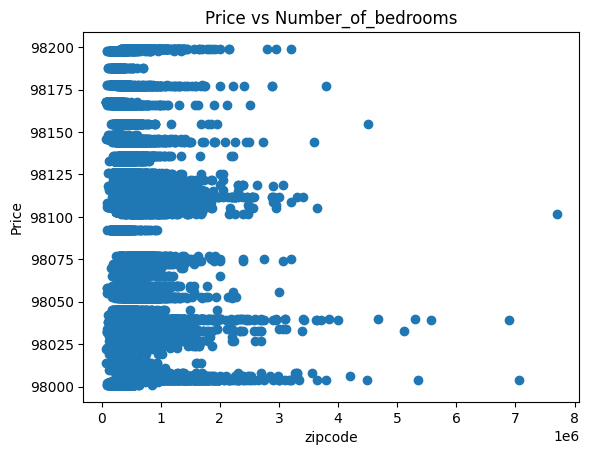

In [64]:
plt.scatter(house_data.price,house_data.zipcode)
plt.xlabel('zipcode')
plt.ylabel('Price')
plt.title("Price vs Number_of_bedrooms")

In [86]:
unique_zipcode = house_data['zipcode'].unique()
print(unique_zipcode)
unique_zipcode[1]


[98178. 98125. 98028. 98136. 98074. 98053. 98003. 98198. 98146. 98038.
 98007. 98115. 98107. 98126. 98019. 98103. 98002. 98133. 98040. 98092.
 98030. 98119. 98112. 98052. 98027. 98117. 98058. 98001. 98056. 98166.
 98023. 98070. 98148. 98105. 98042. 98008. 98059. 98122. 98144. 98004.
 98005. 98034. 98075. 98116. 98010. 98118. 98199. 98032. 98045. 98102.
 98077. 98108. 98168. 98177. 98065. 98029. 98006. 98109. 98022. 98033.
 98155. 98024. 98011. 98031. 98106. 98072. 98188. 98014. 98055. 98039.]


98125.0

In [87]:
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(98178)

GeocoderInsufficientPrivileges: HTTP Error 403: Forbidden

In [81]:
#Get the exact address of the houses with the zipcode data
import requests
# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Create an empty list to store addresses
city_name = {}

# Iterate over each item in unique_zipcode
for zipcode in unique_zipcode:
        city_name[zipcode] = geolocator.geocode(zipcode)
   
   


print(city_name)

ImportError: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'OpenSSL 1.1.0j  20 Nov 2018'. See: https://github.com/urllib3/urllib3/issues/2168

In [63]:

# Using Nominatim API
geolocator = Nominatim(user_agent="my_app")

# Function to get city from zipcode
def get_city(zipcode):
    location = geolocator.geocode(zipcode)
    if location is not None:
        return location.raw.get('address', {}).get('city')
    else:
        return None

# Create 'City' column based on 'Zipcode' column using batch geocoding
batch_size = 1000  
num_batches = len(house_data) // batch_size + 1

# Iterate over house_data in batches and perform batch geocoding
for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    house_data_batch = house_data.iloc[start:end].copy()  # Create a copy of the slice

    # Apply the 'get_city' function to the 'zipcode' column of the batch
    house_data_batch['city'] = house_data_batch['zipcode'].apply(get_city)

    # Update the original DataFrame with the geocoded cities using .loc
    house_data.loc[start:end, 'city'] = house_data_batch['city']


GeocoderTimedOut: Service timed out



The second step we carried out was feature engineering 
we would like to see if there any outliers in our data 
1. Utilize the longtitude and latitude to determine the address of the house 
2. Use year of renovation to determine how recently it was renovated 
3. Use the size of the lot and living space to determine how big the house is 
. If the living space size is relatively large compared to the lot size, it may indicate that the house has more interior space in relation to the land it occupies. Conversely, if the lot size is significantly larger than the living space size, it may suggest a smaller house or a larger outdoor area.



using both zip code and address is
zipcode The ZIP code can be a useful starting point for understanding the general area and market conditions. It can provide an overview of the neighborhood or region where the house is located. ZIP codes are often used in real estate analysis to compare property prices, demographics, and market trends within a particular area. However, using ZIP code alone may not capture the specific characteristics or desirability of a particular address within that ZIP code
using address specific address of the house offers a higher level of accuracy and granularity. It takes into account the unique attributes of the property, such as its proximity to amenities, schools, transportation, and other local factors that can influence the price. The address provides a more precise location for conducting comparable market analyses and evaluating the specific features and qualities of the property.

What features we want to use 
determine how big the house is using the size of the lot and living space
number of bathrooms 
number of bedrooms
has a waterfront or not 
how good the view is 
number of floors
condition of the house
the grade of the house
year renovated
zip

In [4]:
#Get the exact address of the houses with the longtitude and latitude data

# Initialize the geocoder
geolocator = Nominatim(user_agent="my_app")

# Create an empty list to store addresses
addresses = []

# Iterate over each row using itertuples()
for row in house_data.itertuples(index=False):
    address = geolocator.reverse((row.lat, row.long)).address
    addresses.append(address)

# Add the addresses to a new column in the DataFrame
house_data['address'] = addresses

GeocoderTimedOut: Service timed out

In [7]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161